<a href="https://colab.research.google.com/github/ulia414/kotlin/blob/master/Salinan_dari_pima_indians_diabets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import library yang akan digunakan**

In [ ]:
# General tools
import pandas as pd
import numpy as np
import os, math
from collections import Counter

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
morancolor=sns.color_palette(['#6a2202', '#bc7201', '#e5ab09', '#22180d', '#0f1a26','#241c24', '#745656', '#c7b44f', '#977f48', '#392c23'])
plt.style.use("fivethirtyeight")
sns.set_palette(morancolor)

plt.rcParams['font.family']='serif'
plt.rcParams['figure.dpi'] =100 # high resolution

# Manage warnings
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing
from sklearn.preprocessing import QuantileTransformer,scale,normalize,minmax_scale

# Model Selection
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA

# Statistical
import scipy.stats
import statsmodels.api as sm

# **Import Dataset dan menghapus duplikat dan data null**

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/Ulia Putra/diabetes.csv")
df.drop_duplicates(inplace=True)
df.dropna(how='all',inplace=True)
df.sample(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
64,7,114,66,0,0,32.8,0.258,42,1
353,1,90,62,12,43,27.2,0.580,24,0
231,6,134,80,37,370,46.2,0.238,46,1


In [ ]:
!pip install catboost
!pip install scikit-learn
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Melihat info kolom pada dataset (tipe data, nama kolom dan lain lain)**

In [ ]:
df=df.rename(columns={"DiabetesPedigreeFunction":"Dpf"})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pregnancies    768 non-null    int64  
 1   Glucose        768 non-null    int64  
 2   BloodPressure  768 non-null    int64  
 3   SkinThickness  768 non-null    int64  
 4   Insulin        768 non-null    int64  
 5   BMI            768 non-null    float64
 6   Dpf            768 non-null    float64
 7   Age            768 non-null    int64  
 8   Outcome        768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 60.0 KB


# **Melihat overview dataset**

In [ ]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Dpf,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


# **Sorting baris dari dataframe**

In [ ]:
df.isnull().sum().sort_values(ascending=False)

Pregnancies      0
Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
Dpf              0
Age              0
Outcome          0
dtype: int64

# **Melihat nilai minimum pada masing masing kolom**

In [ ]:
df.min()

Pregnancies       0.000
Glucose           0.000
BloodPressure     0.000
SkinThickness     0.000
Insulin           0.000
BMI               0.000
Dpf               0.078
Age              21.000
Outcome           0.000
dtype: float64

# **Membuat perbandingan antara target yang terkena diabetes dan tidak berdasarkan kolom Outcome**

In [ ]:
def despine():
    sns.despine(top=1,bottom=1,right=1,left=1)
    
def title(title,fontsize=13):
    plt.title(title,fontweight='bold',fontsize=fontsize)

In [ ]:
def countplot(df,lst,h=4,w=10,cut=3,hspace=.5,wspace=.25,annotsize=10,color=None):
    f=plt.figure(figsize=(w,h))
    plt.subplots_adjust(hspace=hspace,wspace=wspace)
    for i,col in enumerate(lst):
        ax=f.add_subplot(math.ceil(len(lst)/cut),cut,i+1)
        sns.countplot(df[col],color=color)
        for p in ax.patches:
            ax.annotate(f"{p.get_height()/df[col].shape[0]*100:.2f}%",xy=[p.get_x(),p.get_height()],fontsize=annotsize)
        despine()
        plt.ylabel('')
        plt.xlabel(col,fontweight='bold')

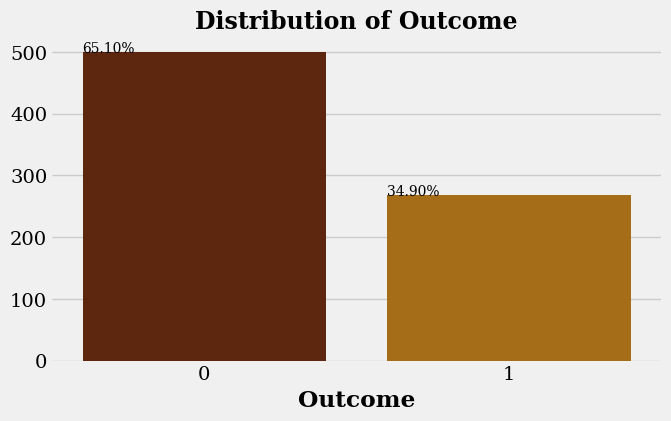

In [ ]:
countplot(df,['Outcome'],annotsize=10,cut=1,w=7)
title('Distribution of Outcome',fontsize=17)

# **Mengisi nilai yang hilang pada dataframe**

In [ ]:
from scipy.stats import skew
def kdeall(df,lst,h=4,w=10,cut=3,hspace=.5,wspace=.25,meanskew=True,kdecut=0,legendsize=10,xlabelsize=13,loc='best'):
    f=plt.figure(figsize=(w,h))
    plt.subplots_adjust(hspace=hspace,wspace=wspace)
    for i,col in enumerate(lst):
        f.add_subplot(math.ceil(len(lst)/cut),cut,i+1)
        if meanskew==True:
            sns.kdeplot(df.dropna(subset=[col])[col],cut=kdecut,label=f'Skewness: {skew(df.dropna(subset=[col])[col]):.2f}',lw=3)
            plt.axvline(df.dropna(subset=[col])[col].mean(),label='mean',color='#22180d',lw=1.5)
            plt.axvline(df.dropna(subset=[col])[col].median(),label='median',ls='--',color='#22180d',lw=1.5)
            plt.legend(fontsize=legendsize,loc=loc)
        else: sns.kdeplot(df.dropna(subset=[col])[col],cut=kdecut,lw=3)
        sns.rugplot(df.dropna(subset=[col])[col])
        despine()
        plt.ylabel('')
        plt.xlabel(col,fontweight='bold',fontsize=xlabelsize)

In [ ]:
def kde2(df,lst,target,h=4,w=10,cut=3,hspace=.5,wspace=.25,xlabel=12):
    f=plt.figure(figsize=(w,h))
    plt.subplots_adjust(hspace=hspace,wspace=wspace)
    for i,col in enumerate(lst):
        ax=f.add_subplot(math.ceil(len(lst)/cut),cut,i+1)
        sns.kdeplot(data=df.dropna(subset=[col,target]),x=col,hue=target,cut=0)
        sns.rugplot(data=df.dropna(subset=[col,target]),x=col,hue=target)
        despine()
        plt.ylabel('')
        plt.xlabel(col,fontweight='bold',fontsize=xlabel)

In [ ]:
def boxall(df,lst,hspace=.5,wspace=.25,cut=3,h=7,w=10,target=None):
    f=plt.figure(figsize=(w,h))
    for i,col in enumerate(lst):
        f.add_subplot(math.ceil(len(lst)/cut),cut,i+1)
        if target==None: sns.boxplot(y=df[col],showmeans=True)
        else: sns.boxplot(x=df[target],y=df[col],showmeans=True)
        plt.ylabel('')
        plt.xlabel(col,fontweight='bold')
        sns.despine(top=1,bottom=1,left=1,right=1)
    plt.subplots_adjust(hspace=hspace,wspace=wspace)

In [ ]:
def barall(df,lst,target,hspace=.5,wspace=.25,cut=3,h=7,w=10,color=None):
    f=plt.figure(figsize=(w,h))
    for i,col in enumerate(lst):
        f.add_subplot(math.ceil(len(lst)/cut),cut,i+1)
        sns.barplot(y=df[target],x=df[col],color=color)
        plt.xlabel(col,fontweight='bold')
        sns.despine(top=1,bottom=1,left=1,right=1)
    plt.subplots_adjust(hspace=hspace,wspace=wspace)

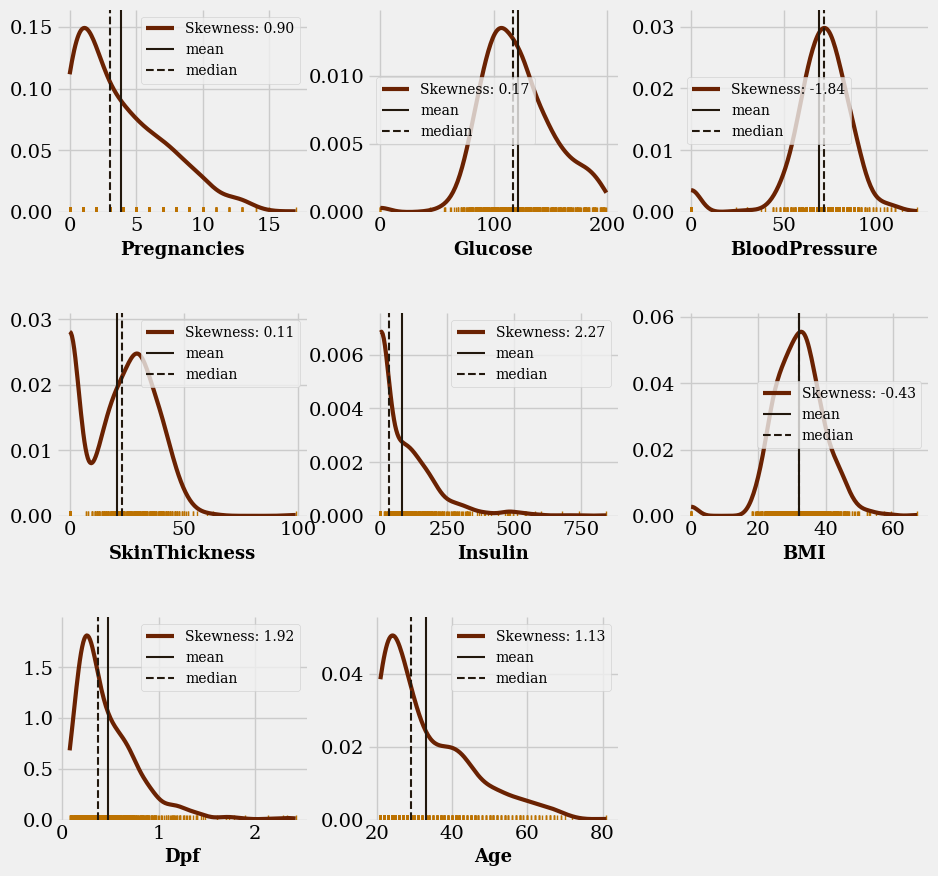

In [ ]:
numcol=df.columns.tolist()[:-1]
kdeall(df,numcol,h=10)

In [ ]:
def fillna(df,lst,target):
    for col in lst:
        missing_ind=df[df[col]==0].index.tolist()
        fill={i:df[col][df[target]==df[target].iloc[i]].mean() for i in missing_ind}
        for ind,x in fill.items(): df.loc[ind,col]=x

In [ ]:
lst=["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]
fillna(df,lst,'Outcome')

In [ ]:
df.min()

Pregnancies       0.000
Glucose          44.000
BloodPressure    24.000
SkinThickness     7.000
Insulin          14.000
BMI              18.200
Dpf               0.078
Age              21.000
Outcome           0.000
dtype: float64

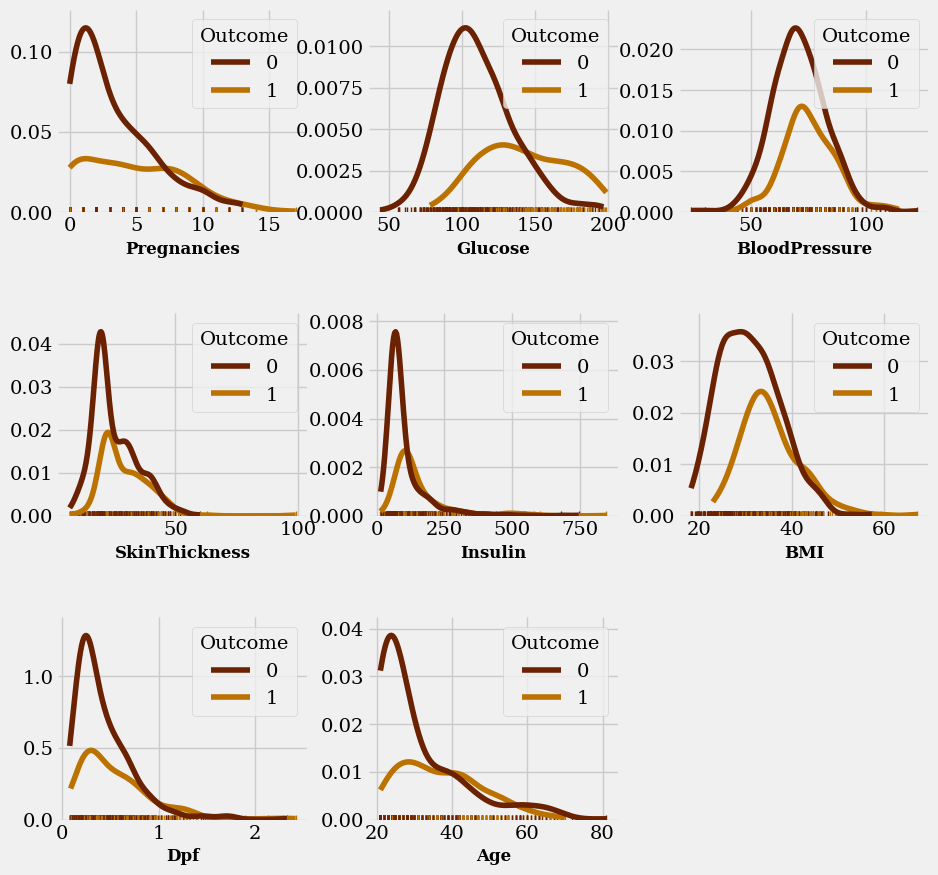

In [ ]:
kde2(df,numcol,h=10,target='Outcome')

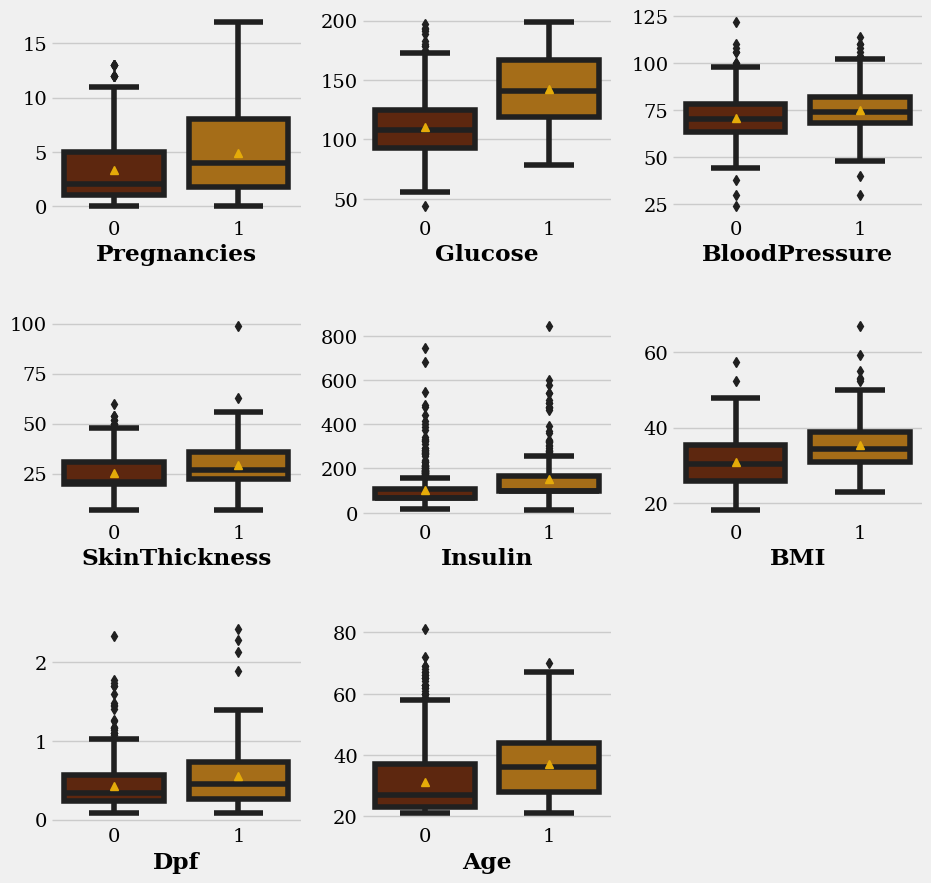

In [ ]:
boxall(df,numcol,h=10,cut=3,w=10,target='Outcome')

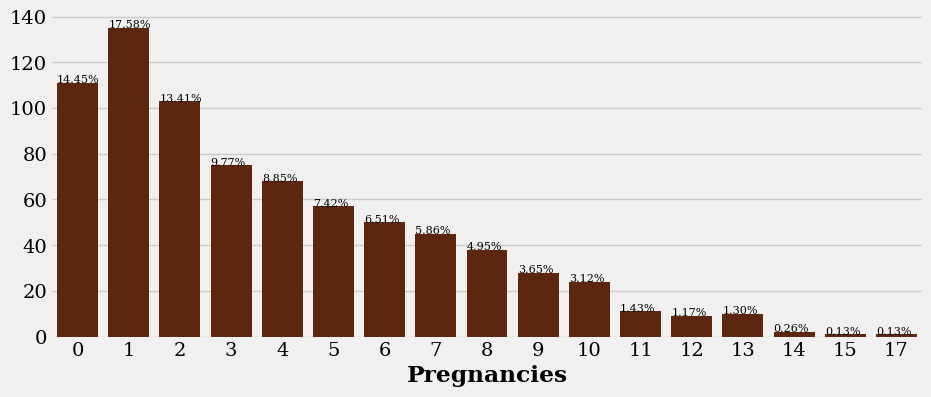

In [ ]:
countplot(df,["Pregnancies"],color='#6a2202',annotsize=8,cut=1)

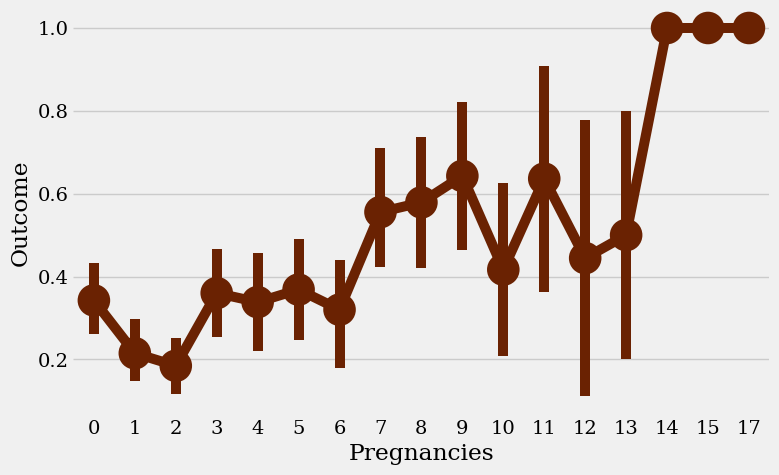

In [ ]:
f,ax=plt.subplots(figsize=(8,5))
sns.pointplot(df.Pregnancies,df.Outcome)
despine()

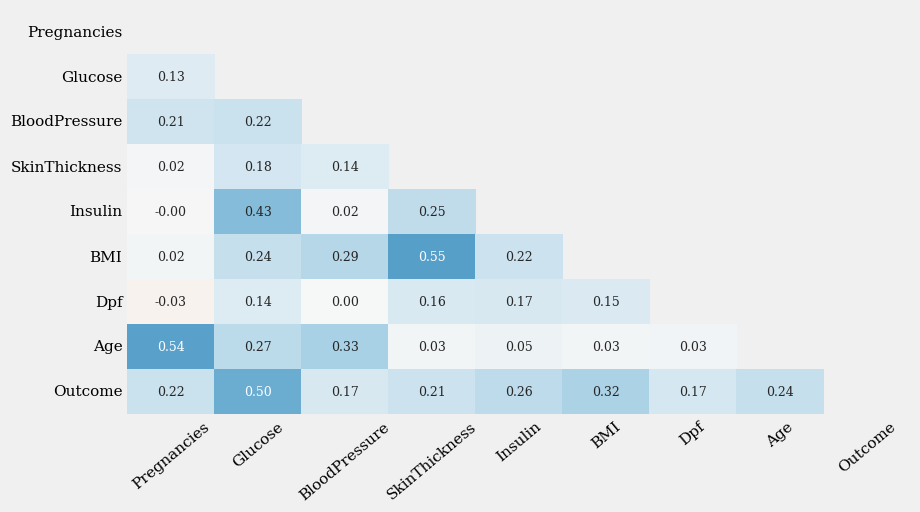

In [ ]:
mask = np.triu(np.ones_like(df.corr()))
f=plt.figure(figsize=(9,5))
sns.heatmap(df.corr(),cmap='RdBu',vmax=1,vmin=-1,mask=mask,annot=True,fmt='.2f',annot_kws={"size":9},cbar=False)
plt.yticks(fontsize=11)
plt.xticks(fontsize=11,rotation=40)
plt.show()

In [ ]:
def outlier(df,features,fence=1.5,n=1):
    outliers=[]
    for col in features:
        q1=np.percentile(df[col],25)
        q3=np.percentile(df[col],75)
        iqr=q3-q1
        outliers_list_col=df[(df[col]<q1-iqr*fence)|(df[col]>q3+iqr*fence)].index
        outliers.extend(outliers_list_col)
    outliers=Counter(outliers)
    multiple_outliers=list(key for key,value in outliers.items() if value>=n)
    return multiple_outliers

In [ ]:
mostimp=["Glucose","BMI","Age"]
df.describe()[mostimp]

,Glucose,BMI,Age
count,768.000000,768.000000,768.000000
mean,121.691999,32.439222,33.240885
std,30.461151,6.880449,11.760232
min,44.000000,18.200000,21.000000
25%,99.750000,27.500000,24.000000
50%,117.000000,32.050000,29.000000
75%,141.000000,36.600000,41.000000
max,199.000000,67.100000,81.000000


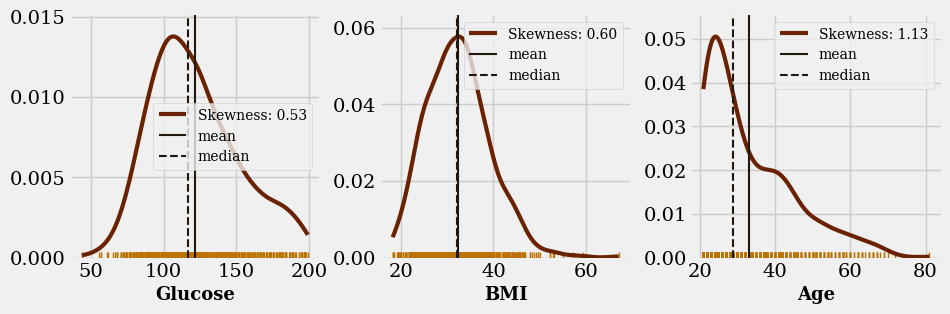

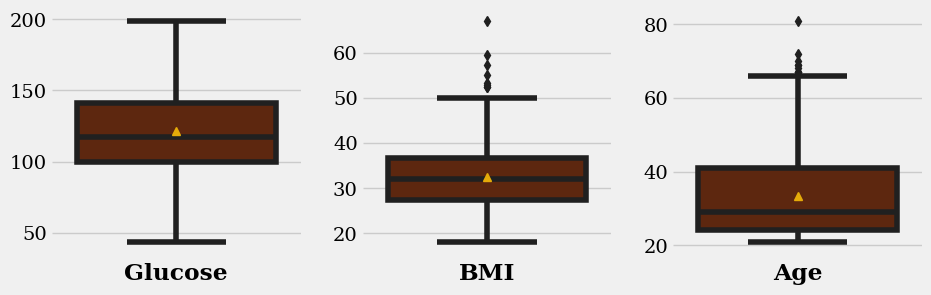

In [ ]:
kdeall(df,mostimp,h=3,cut=3)
boxall(df,mostimp,h=3,cut=3)

In [ ]:
df.iloc[outlier(df,['BMI'])]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Dpf,Age,Outcome
120,0,162.0,76.000000,56.000000,100.000000,53.2,0.759,25,1
125,1,88.0,30.000000,42.000000,99.000000,55.0,0.496,26,1
177,0,129.0,110.000000,46.000000,130.000000,67.1,0.319,26,1
193,11,135.0,70.824627,22.164179,100.335821,52.3,0.578,40,1
247,0,165.0,90.000000,33.000000,680.000000,52.3,0.427,23,0
303,5,115.0,98.000000,22.164179,100.335821,52.9,0.209,28,1
445,0,180.0,78.000000,63.000000,14.000000,59.4,2.420,25,1
673,3,123.0,100.000000,35.000000,240.000000,57.3,0.880,22,0


In [ ]:
df.iloc[outlier(df,['Age'])]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Dpf,Age,Outcome
123,5,132.0,80.000,19.664000,68.792000,26.8000,0.186,69,0
363,4,146.0,78.000,22.164179,100.335821,38.5000,0.520,67,1
453,2,119.0,68.184,19.664000,68.792000,19.6000,0.832,72,0
459,9,134.0,74.000,33.000000,60.000000,25.9000,0.460,81,0
489,8,194.0,80.000,19.664000,68.792000,26.1000,0.551,67,0
537,0,57.0,60.000,19.664000,68.792000,21.7000,0.735,67,0
666,4,145.0,82.000,18.000000,100.335821,32.5000,0.235,70,1
674,8,91.0,82.000,19.664000,68.792000,35.6000,0.587,68,0
684,5,136.0,82.000,19.664000,68.792000,30.3042,0.640,69,0


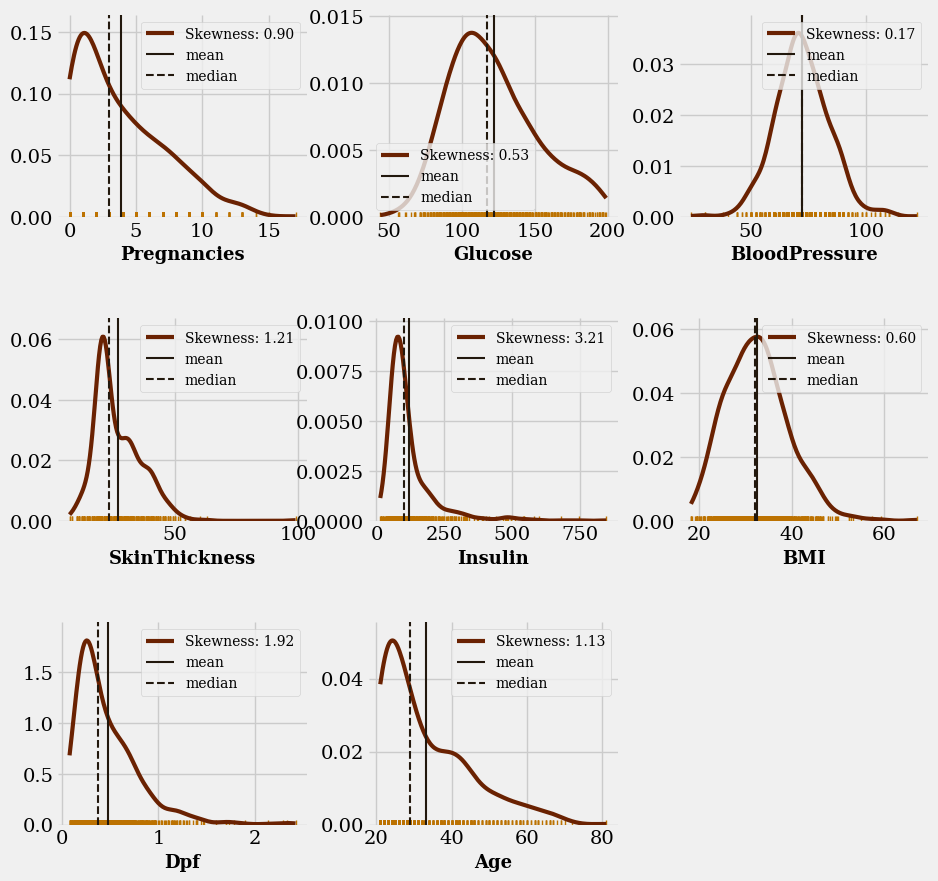

In [ ]:
kdeall(df,numcol,h=10)

In [ ]:
for i in ["Pregnancies","Insulin","Dpf","Age","SkinThickness"]:
    df[i]=normalize(df[i].values.reshape(-1,1),norm='max',axis=0)

In [ ]:
df.BloodPressure=scale(df.BloodPressure.values).reshape(-1,1)

In [ ]:
for i in ["Glucose","BMI"]: df[i]=minmax_scale(df[i].values.reshape(-1,1))

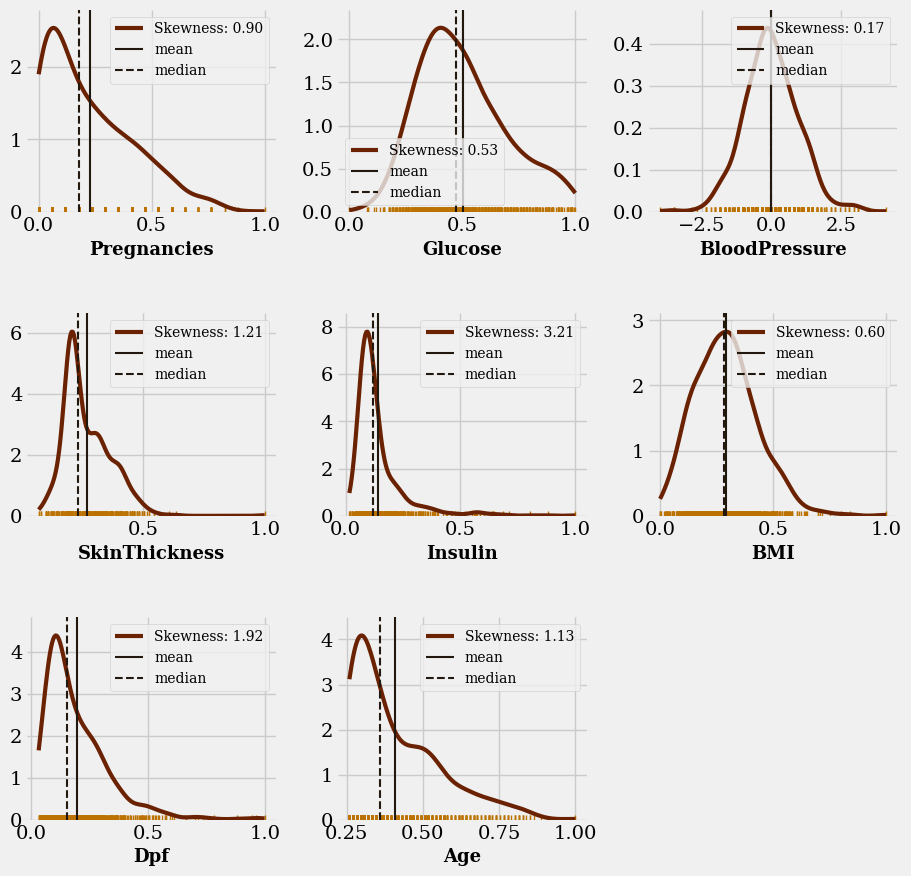

In [ ]:
kdeall(df,numcol,h=10)

Fitur Seleksi

In [ ]:
X=df.drop(columns='Outcome')
y=df.Outcome
X.shape,y.shape

((768, 8), (768,))

In [ ]:
((768, 8), (768,))

((768, 8), (768,))

In [ ]:
from sklearn.model_selection import StratifiedKFold
def check(clf,X,y=y,n_splits=10):
    kf=StratifiedKFold(n_splits=n_splits,random_state=0,shuffle=True)
    k_tracc,k_teacc=[],[]
    for (tr,te) in kf.split(X,y):
        clf.fit(X.iloc[tr],y.iloc[tr])
        k_tracc.append(clf.score(X.iloc[tr],y.iloc[tr]))
        k_teacc.append(clf.score(X.iloc[te],y.iloc[te]))
    print(f"Train score: {np.mean(k_tracc)}")
    print(f"Test score: {np.mean(k_teacc)}")
    return clf

In [ ]:
def selectmoran(modellst,X,y=y,n_splits=10,random_state=0):
    kf=StratifiedKFold(n_splits=n_splits,random_state=random_state,shuffle=True)
    namelst,imp,tr_acc,te_acc=[],[],[],[]
    for clf in modellst:
        namelst.append(type(clf).__name__)
        k_tracc, k_teacc, k_f1, k_imp=[],[],[],[]
        for (tr,te) in kf.split(X,y): # train, test index
            clf.fit(X.iloc[tr],y.iloc[tr])
            k_tracc.append(clf.score(X.iloc[tr],y.iloc[tr]))
            k_teacc.append(clf.score(X.iloc[te],y.iloc[te]))
            if hasattr(clf,"feature_importances_"): k_imp.append(clf.feature_importances_)
        tr_acc.append(np.mean(k_tracc))
        te_acc.append(np.mean(k_teacc))
        if len(k_imp)==0: imp.append(False)
        else: imp.append(np.mean(k_imp,axis=0))
    score=pd.DataFrame({'Model':namelst,'Train_accuracy':tr_acc,'Test_accuracy':te_acc}).sort_values('Test_accuracy',ascending=False)
    return score,imp

In [ ]:
def plotscoring(score,title,w=7,h=5,alpha=.97,axvline=.8,yticksize=12):
    f,ax=plt.subplots(figsize=(w,h))
    print(f"Mean accuracy for all models: {np.mean(score.Test_accuracy)}\n")
    print(score)
    sns.barplot(x=score.Test_accuracy,y=score.Model,alpha=alpha,color='#bc7201')
    sns.barplot(x=-score.Train_accuracy,y=score.Model,alpha=alpha,color='#6a2202')
    ax.set_xlim(-1,1)
    plt.axvline(x=0,color='black')
    plt.xlabel('Train/ Test accuracy')
    plt.ylabel('')
    plt.title(f"Accuracy score for {title}",fontweight='bold')
    plt.axvline(x=axvline,ls=':')
    plt.yticks(fontsize=yticksize)
    despine()

In [ ]:
from sklearn.model_selection import GridSearchCV
def grid(clf,params,X,y=y,cv=5):
    grid=GridSearchCV(clf,params,cv=cv)
    grid.fit(X,y)
    print(f"Best score: {grid.best_score_}")
    print(f"Best params: {grid.best_params_}")
    return grid.best_estimator_

In [ ]:
def plotting_importances(score,imp,X,w=8,h=3,rotation=90,xsize=10):
    for (a,b) in zip(score.Model,imp):
        if b is not False:
            ind=np.argsort(b)[::-1]
            cols=X.columns
            plt.figure(figsize=(w,h))
            plt.title(f"Feature importances via {a}",fontweight='bold',fontsize=13)
            plt.bar(range(X.shape[1]),b[ind])
            plt.xticks(range(X.shape[1]),cols[ind],rotation=rotation,fontsize=xsize)
            plt.xlim([-1,X.shape[1]])
            plt.tight_layout()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,BaggingRegressor,GradientBoostingClassifier,AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC

modellst=[LogisticRegression(),
          ExtraTreesClassifier(),RandomForestClassifier(),
          BaggingRegressor(base_estimator=DecisionTreeClassifier(),n_estimators=50),
          GradientBoostingClassifier(),
         XGBClassifier(),
         LGBMClassifier(),
          CatBoostClassifier(),
         SVC()]

Pengurangan dimensi melalui PCA

In [ ]:
from sklearn.decomposition import PCA
def reduct_pca(X,w=8,h=3):
    pca=PCA(n_components=X.shape[1],random_state=0)
    Xpca=pca.fit_transform(X)
    f=plt.figure(figsize=(w,h))
    plt.bar(range(1,X.shape[1]+1),pca.explained_variance_ratio_,label='individual explained variance')
    plt.step(range(1,X.shape[1]+1), np.cumsum(pca.explained_variance_ratio_),where='mid',label='cumulative explained variance')
    plt.xticks(range(1,X.shape[1]+1))
    plt.xlabel('# of principal components')
    plt.ylabel('explained variance ratio',fontsize=13)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12,loc='best')
    despine()
    return Xpca

(768, 4)

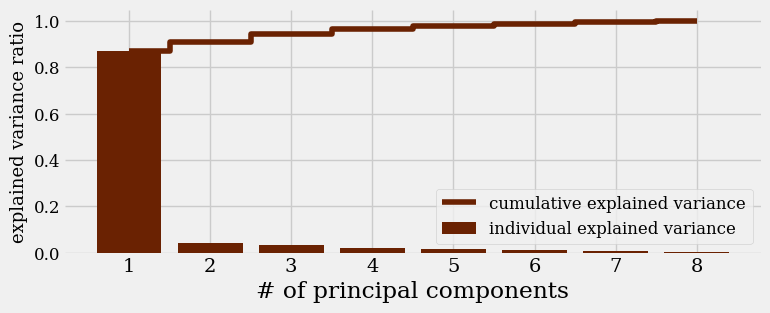

In [ ]:
Xpca=pd.DataFrame(reduct_pca(X)[:,:4])
Xpca.shape

Menggunakan nilai-P

In [ ]:
import statsmodels.api as sm
def select_by_pvalue(target,df,fence=.05,w=7,h=5,textw=.5,texth=.2):
    mod=sm.OLS(df[target],df.drop(target,axis=1))
    fii=mod.fit()
    sub=fii.summary2().tables[1]["P>|t|"].sort_values()
    sub.plot(kind='barh',figsize=(w,h))
    pvalue_set=sub[sub<=fence].index.tolist()
    plt.axvline(x=fence,c='black')
    plt.figtext(textw, texth, 'dropped',fontsize=15, fontweight='bold')
    return pvalue_set


In [ ]:
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
def vif(x):
    X=add_constant(x)
    return pd.Series([variance_inflation_factor(X.values,i) for i in range(X.shape[1])],index=X.columns).sort_values(ascending=False)

['Glucose', 'BloodPressure', 'Pregnancies', 'BMI', 'DiabetesPedigreeFunction']

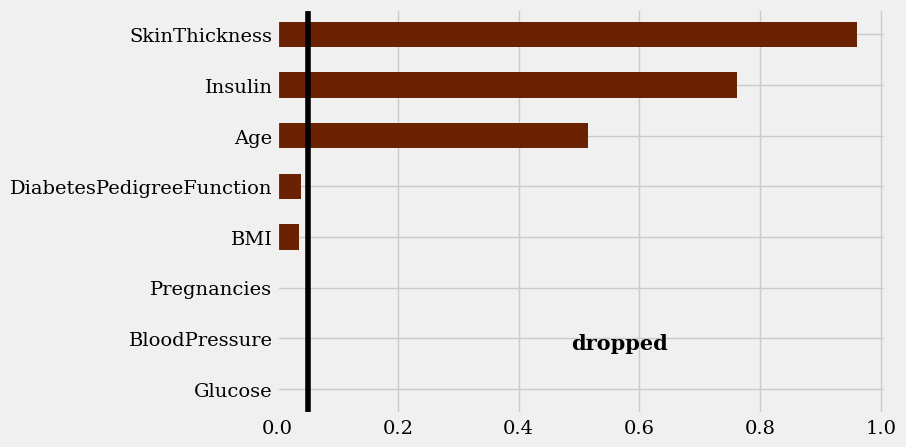

In [ ]:
pval_set=select_by_pvalue("Outcome",df)
pval_set

In [ ]:
['Glucose', 'Pregnancies', 'BMI', 'Age', 'SkinThickness', 'BloodPressure']

['Glucose', 'Pregnancies', 'BMI', 'Age', 'SkinThickness', 'BloodPressure']

In [ ]:
vif(X)

const            21.874032
Age               1.605841
BMI               1.582373
SkinThickness     1.475489
Pregnancies       1.430254
Glucose           1.390272
Insulin           1.310917
BloodPressure     1.253560
Dpf               1.059081
dtype: float64

In [ ]:
vif(X[pval_set])

**Modeling**

In [ ]:
scorefull,impfull=selectmoran(modellst,X)

Output streaming akan dipotong hingga 5000 baris terakhir.
4:	learn: 0.6498259	total: 11.3ms	remaining: 2.25s
5:	learn: 0.6420233	total: 14ms	remaining: 2.32s
6:	learn: 0.6334868	total: 16.4ms	remaining: 2.32s
7:	learn: 0.6246333	total: 18.6ms	remaining: 2.31s
8:	learn: 0.6157963	total: 20.8ms	remaining: 2.29s
9:	learn: 0.6097206	total: 23ms	remaining: 2.28s
10:	learn: 0.6024291	total: 25.6ms	remaining: 2.3s
11:	learn: 0.5951507	total: 28ms	remaining: 2.31s
12:	learn: 0.5874984	total: 30.2ms	remaining: 2.29s
13:	learn: 0.5813028	total: 32.2ms	remaining: 2.27s
14:	learn: 0.5740072	total: 34.3ms	remaining: 2.25s
15:	learn: 0.5674130	total: 36.4ms	remaining: 2.24s
16:	learn: 0.5612637	total: 38.6ms	remaining: 2.23s
17:	learn: 0.5558053	total: 41.7ms	remaining: 2.27s
18:	learn: 0.5493731	total: 43.8ms	remaining: 2.26s
19:	learn: 0.5438777	total: 47.5ms	remaining: 2.33s
20:	learn: 0.5380674	total: 49.9ms	remaining: 2.33s
21:	learn: 0.5324410	total: 52.9ms	remaining: 2.35s
22:	learn: 0.52674

Mean accuracy for all models: 0.8326325776317681

                        Model  Train_accuracy  Test_accuracy
5               XGBClassifier        0.968897       0.893250
6              LGBMClassifier        1.000000       0.891917
2      RandomForestClassifier        1.000000       0.890687
4  GradientBoostingClassifier        0.981481       0.890687
7          CatBoostClassifier        0.989149       0.889388
1        ExtraTreesClassifier        1.000000       0.852956
8                         SVC        0.791233       0.766986
0          LogisticRegression        0.771413       0.765636
3            BaggingRegressor        0.950187       0.652186


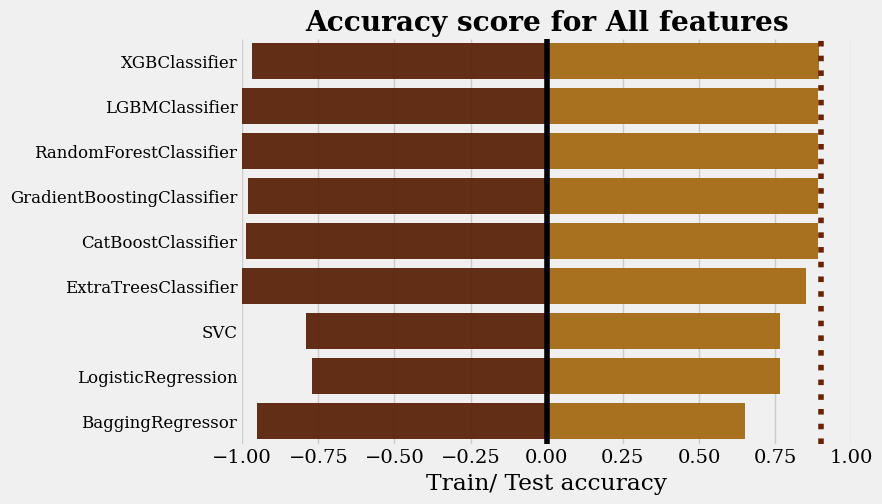

In [ ]:
plotscoring(scorefull,'All features',axvline=.9)

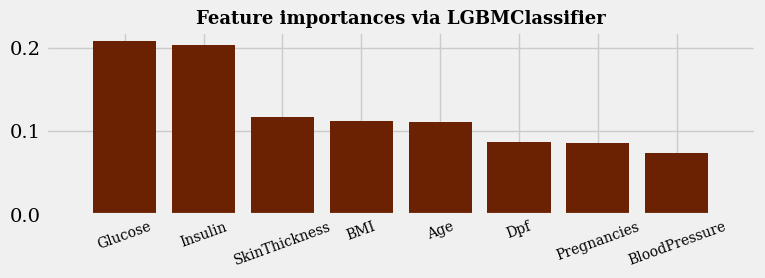

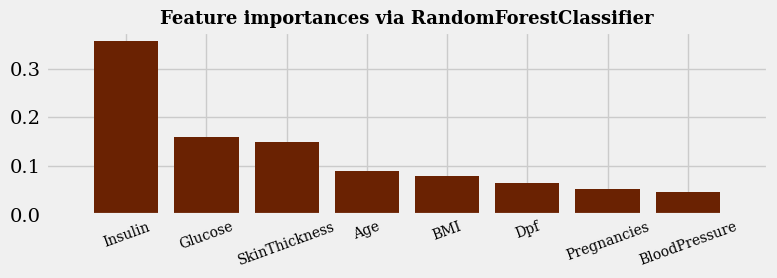

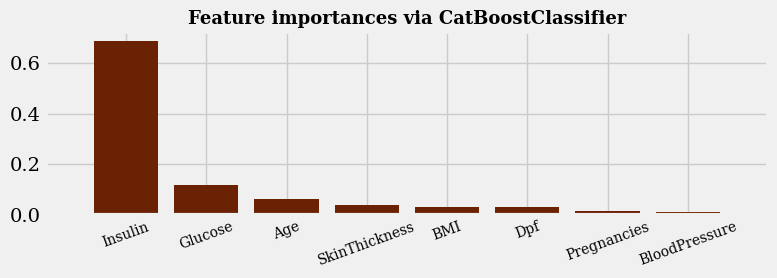

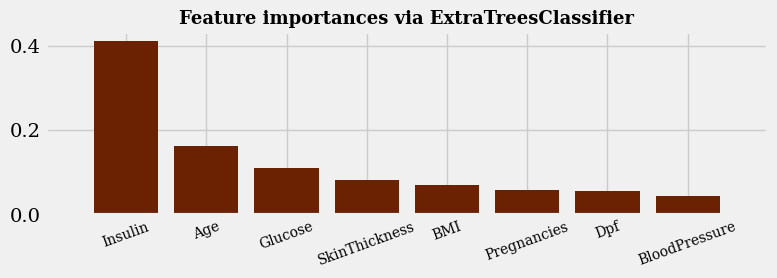

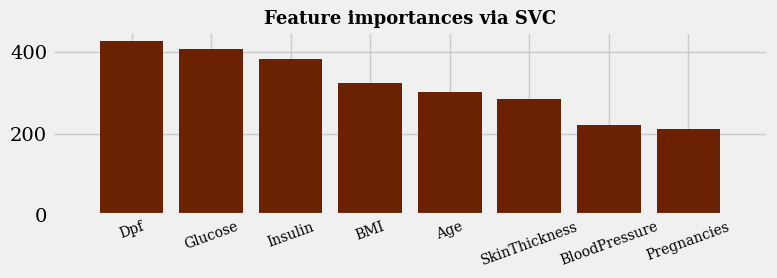

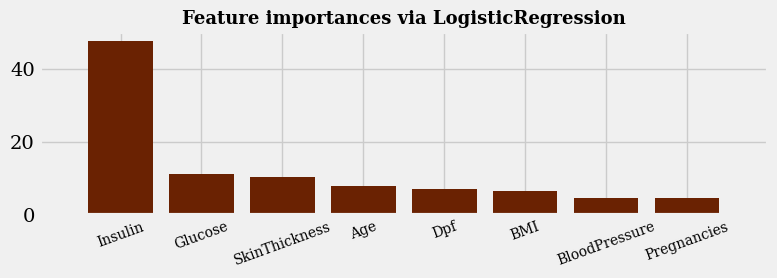

In [ ]:
plotting_importances(scorefull,impfull,X,rotation=20)

In [ ]:
pval_set

['Glucose', 'BloodPressure', 'Pregnancies', 'BMI', 'DiabetesPedigreeFunction']

In [ ]:
scorepval,imppval=selectmoran(modellst,X[pval_set])

KeyError: ignored

Mean accuracy for all models: 0.7734071570663255

                        Model  Train_accuracy  Test_accuracy
5               XGBClassifier        0.917244       0.851589
4  GradientBoostingClassifier        0.938947       0.847676
2      RandomForestClassifier        0.999855       0.842498
6              LGBMClassifier        0.999277       0.835919
1        ExtraTreesClassifier        1.000000       0.815174
0          LogisticRegression        0.767651       0.764337
7                         SVC        0.778793       0.759211
3            BaggingRegressor        0.924690       0.470853


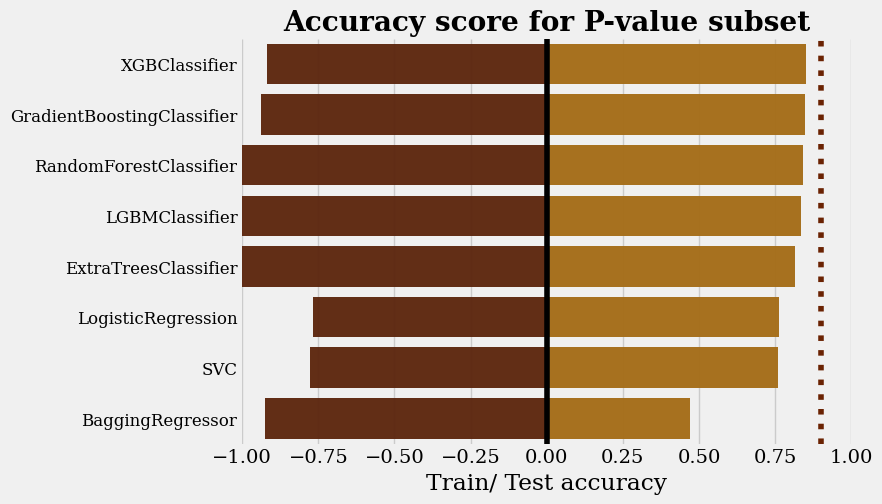

In [ ]:
plotscoring(scorepval,'P-value subset',axvline=.9)

In [ ]:
plotting_importances(scorepval,imppval,X[pval_set],rotation=20)

KeyError: ignored

PCA subset

In [ ]:
scorepca,imppca=selectmoran(modellst,Xpca)

Output streaming akan dipotong hingga 5000 baris terakhir.
4:	learn: 0.6716702	total: 13.6ms	remaining: 2.7s
5:	learn: 0.6667222	total: 15.5ms	remaining: 2.57s
6:	learn: 0.6624338	total: 17.5ms	remaining: 2.48s
7:	learn: 0.6576523	total: 19.5ms	remaining: 2.42s
8:	learn: 0.6534133	total: 21.4ms	remaining: 2.36s
9:	learn: 0.6493979	total: 23.3ms	remaining: 2.31s
10:	learn: 0.6451737	total: 25.3ms	remaining: 2.27s
11:	learn: 0.6408163	total: 27.6ms	remaining: 2.27s
12:	learn: 0.6384906	total: 29.5ms	remaining: 2.24s
13:	learn: 0.6346450	total: 31.8ms	remaining: 2.24s
14:	learn: 0.6314658	total: 35.6ms	remaining: 2.33s
15:	learn: 0.6291741	total: 38.3ms	remaining: 2.35s
16:	learn: 0.6260094	total: 41.7ms	remaining: 2.41s
17:	learn: 0.6226350	total: 43.5ms	remaining: 2.37s
18:	learn: 0.6192994	total: 45.8ms	remaining: 2.37s
19:	learn: 0.6157827	total: 48.2ms	remaining: 2.36s
20:	learn: 0.6127336	total: 50.7ms	remaining: 2.37s
21:	learn: 0.6090681	total: 53ms	remaining: 2.35s
22:	learn: 0.6

Mean accuracy for all models: 0.6967484657157873

                        Model  Train_accuracy  Test_accuracy
7          CatBoostClassifier        0.928386       0.763055
8                         SVC        0.780672       0.761791
0          LogisticRegression        0.765335       0.761722
2      RandomForestClassifier        1.000000       0.759176
4  GradientBoostingClassifier        0.900319       0.757843
5               XGBClassifier        0.874713       0.751282
1        ExtraTreesClassifier        1.000000       0.746104
6              LGBMClassifier        0.996383       0.734433
3            BaggingRegressor        0.889124       0.235329


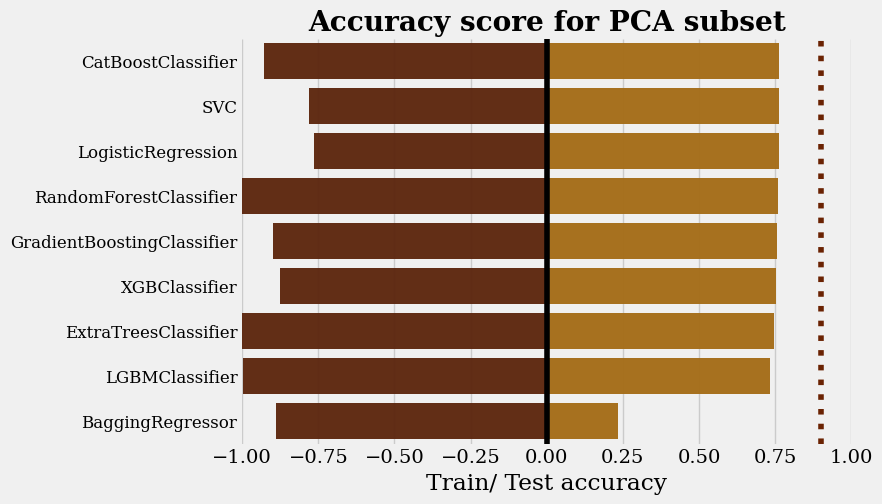

In [ ]:
plotscoring(scorepca,'PCA subset',axvline=.9)

In [ ]:
eda_set=["Glucose","BMI","Age","Pregnancies","Insulin"]
scoreeda,impeda=selectmoran(modellst,X[eda_set])

Output streaming akan dipotong hingga 5000 baris terakhir.
4:	learn: 0.6530045	total: 11.1ms	remaining: 2.21s
5:	learn: 0.6443998	total: 12.9ms	remaining: 2.13s
6:	learn: 0.6368344	total: 14.6ms	remaining: 2.06s
7:	learn: 0.6290097	total: 17.1ms	remaining: 2.13s
8:	learn: 0.6214138	total: 19.6ms	remaining: 2.15s
9:	learn: 0.6132036	total: 21.8ms	remaining: 2.15s
10:	learn: 0.6050759	total: 24.5ms	remaining: 2.2s
11:	learn: 0.5967900	total: 25.9ms	remaining: 2.13s
12:	learn: 0.5899241	total: 27.4ms	remaining: 2.08s
13:	learn: 0.5831122	total: 29.4ms	remaining: 2.07s
14:	learn: 0.5767527	total: 31.2ms	remaining: 2.05s
15:	learn: 0.5700852	total: 33.3ms	remaining: 2.05s
16:	learn: 0.5625987	total: 35.9ms	remaining: 2.07s
17:	learn: 0.5564434	total: 38.2ms	remaining: 2.08s
18:	learn: 0.5498864	total: 39.9ms	remaining: 2.06s
19:	learn: 0.5434188	total: 41.7ms	remaining: 2.04s
20:	learn: 0.5362841	total: 43.4ms	remaining: 2.02s
21:	learn: 0.5294577	total: 45.1ms	remaining: 2s
22:	learn: 0.52

Mean accuracy for all models: 0.8363949503057481

                        Model  Train_accuracy  Test_accuracy
4  GradientBoostingClassifier        0.972656       0.902392
5               XGBClassifier        0.957611       0.897198
6              LGBMClassifier        1.000000       0.895899
7          CatBoostClassifier        0.980757       0.890704
2      RandomForestClassifier        1.000000       0.890636
1        ExtraTreesClassifier        1.000000       0.858100
8                         SVC        0.795719       0.777427
0          LogisticRegression        0.771123       0.769532
3            BaggingRegressor        0.949198       0.645668


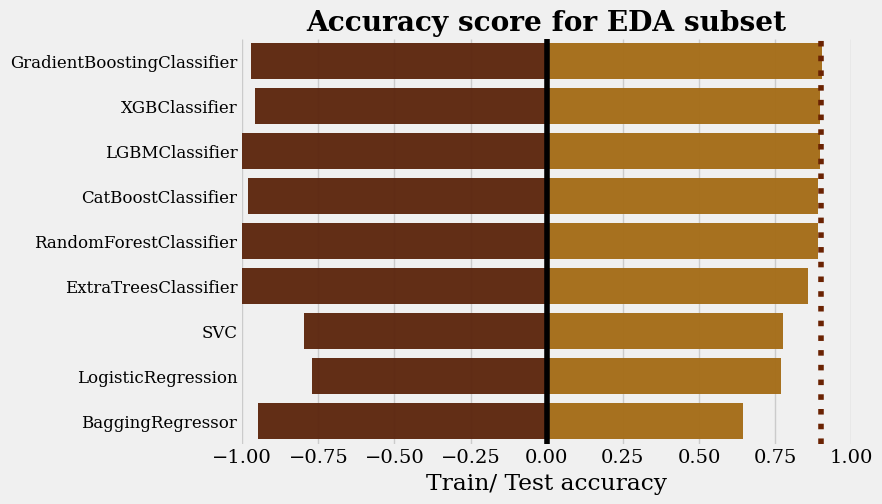

In [ ]:
plotscoring(scoreeda,'EDA subset',axvline=.9)

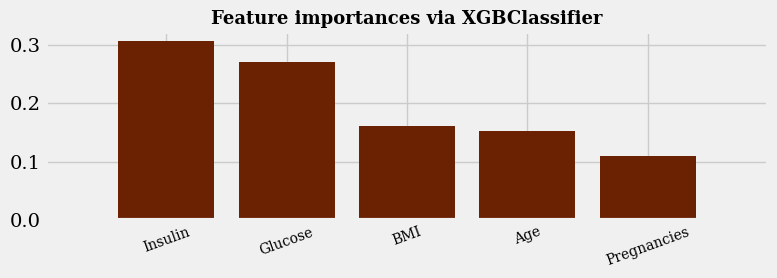

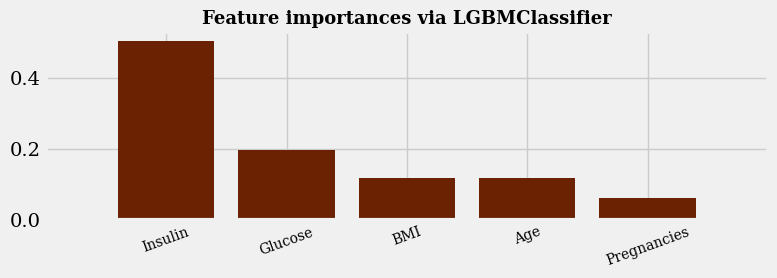

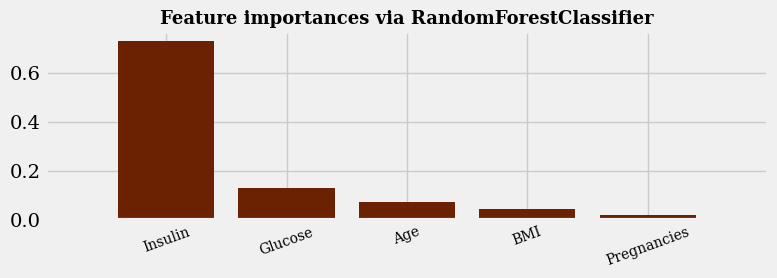

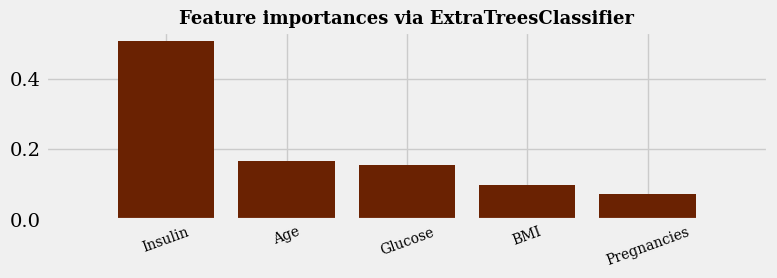

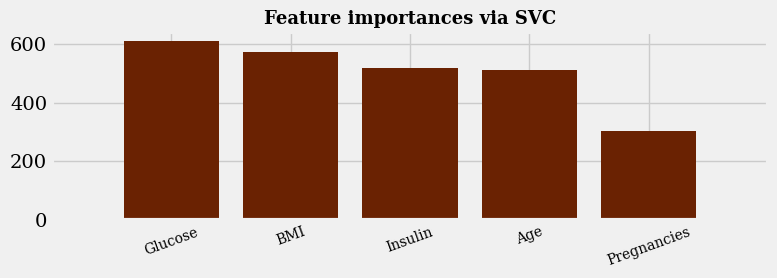

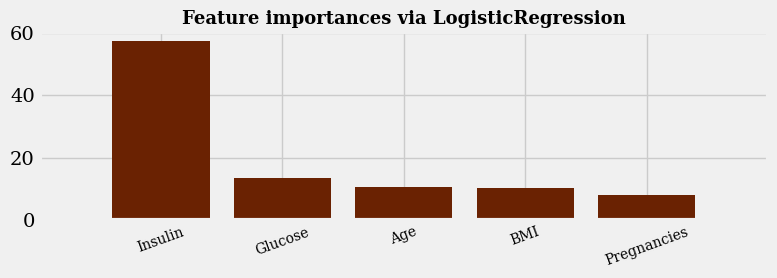

In [ ]:
plotting_importances(scoreeda,impeda,X[eda_set],rotation=20)

## **Kesimpulan**

In [ ]:
def plot_meanscore(meanscore_set,axvline=.9):
    print(meanscore_set)
    f=plt.figure(figsize=(8,3))
    meanscore_set.Test_accuracy[::-1].plot(kind='barh',color='#0f1a26',alpha=.95)
    (-1*meanscore_set.Train_accuracy[::-1]).plot(kind='barh',alpha=.95)
    plt.axvline(x=0,c='black')
    plt.xlim([-1,1])
    plt.axvline(x=axvline,ls=':')
    despine()

In [ ]:
meanscore=pd.DataFrame({'Test_accuracy':[np.mean(i.Test_accuracy) for i in [scorefull,scoreeda,scorepca,scorepval]],
             'Train_accuracy':[np.mean(i.Train_accuracy) for i in [scorefull,scoreeda,scorepca,scorepval]]},
             index=['All features','EDA subset','PCA subset','P-value subset']).sort_values('Test_accuracy',ascending=False)

mxscore=pd.DataFrame({'Test_accuracy':[np.max(i.Test_accuracy) for i in [scorefull,scoreeda,scorepca,scorepval]],
             'Train_accuracy':[np.max(i.Train_accuracy) for i in [scorefull,scoreeda,scorepca,scorepval]]},
             index=['All features','EDA subset','PCA subset','P-value subset']).sort_values('Test_accuracy',ascending=False)

                Test_accuracy  Train_accuracy
EDA subset           0.836395        0.936341
All features         0.832633        0.939151
P-value subset       0.773407        0.915807
PCA subset           0.696748        0.903881


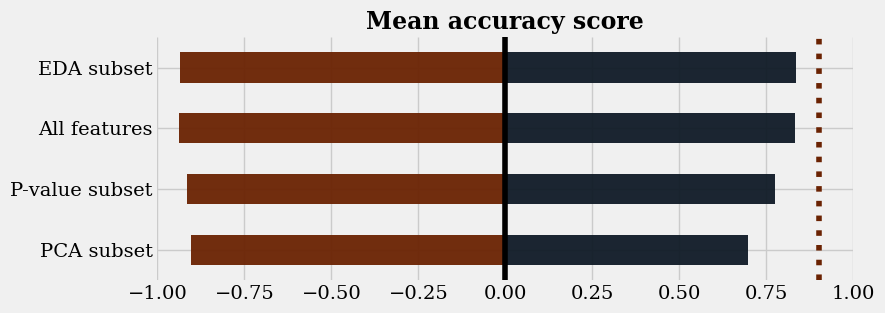

In [ ]:
plot_meanscore(meanscore)
title('Mean accuracy score',fontsize=17)

                Test_accuracy  Train_accuracy
EDA subset           0.902392             1.0
All features         0.893250             1.0
P-value subset       0.851589             1.0
PCA subset           0.763055             1.0


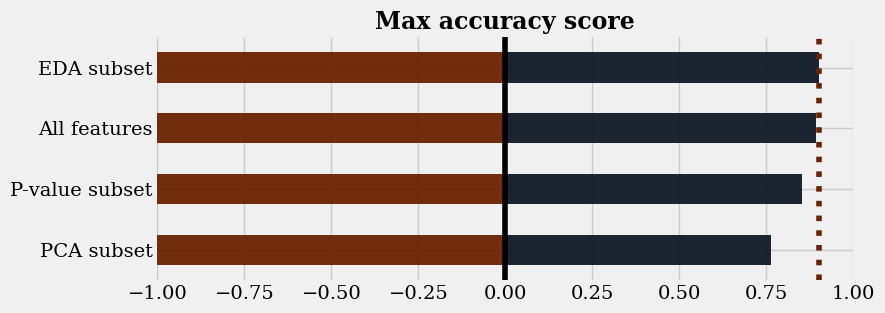

In [ ]:
plot_meanscore(mxscore)
title('Max accuracy score',fontsize=17)

Mean accuracy for all models: 0.7868599188894709

                        Model  Train_accuracy  Test_accuracy
3  GradientBoostingClassifier        0.948351       0.849650
8               XGBClassifier        0.929616       0.848330
1          CatBoostClassifier        0.966097       0.847716
6      RandomForestClassifier        0.999964       0.845749
4              LGBMClassifier        0.998915       0.839542
2        ExtraTreesClassifier        1.000000       0.818084
7                         SVC        0.786604       0.766353
5          LogisticRegression        0.768881       0.765307
0            BaggingRegressor        0.928300       0.501009


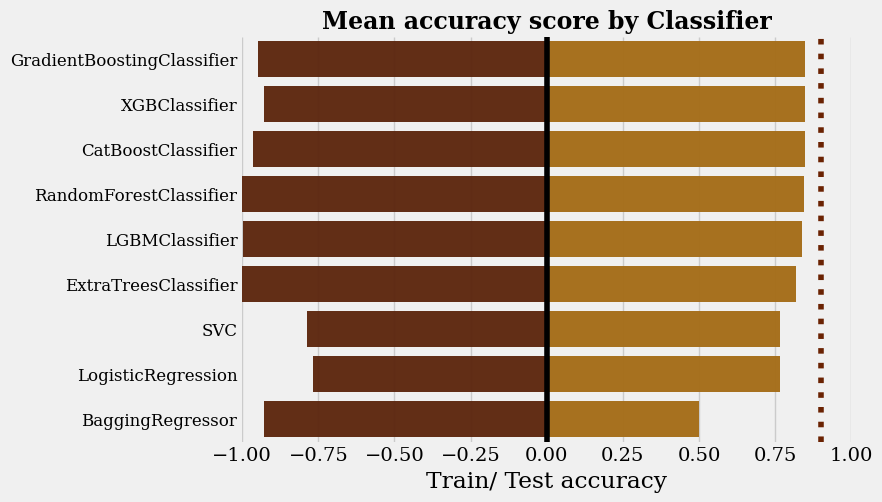

In [ ]:
plotscoring(pd.concat([scorefull,scoreeda,scorepca,scorepval]).groupby('Model').aggregate(np.mean).reset_index().sort_values('Test_accuracy',ascending=False),'M',axvline=.9)
title('Mean accuracy score by Classifier',fontsize=17)

## Parameter hyperturning

bagian EDA

Mean accuracy for all models: 0.8363949503057481

                        Model  Train_accuracy  Test_accuracy
4  GradientBoostingClassifier        0.972656       0.902392
5               XGBClassifier        0.957611       0.897198
6              LGBMClassifier        1.000000       0.895899
7          CatBoostClassifier        0.980757       0.890704
2      RandomForestClassifier        1.000000       0.890636
1        ExtraTreesClassifier        1.000000       0.858100
8                         SVC        0.795719       0.777427
0          LogisticRegression        0.771123       0.769532
3            BaggingRegressor        0.949198       0.645668


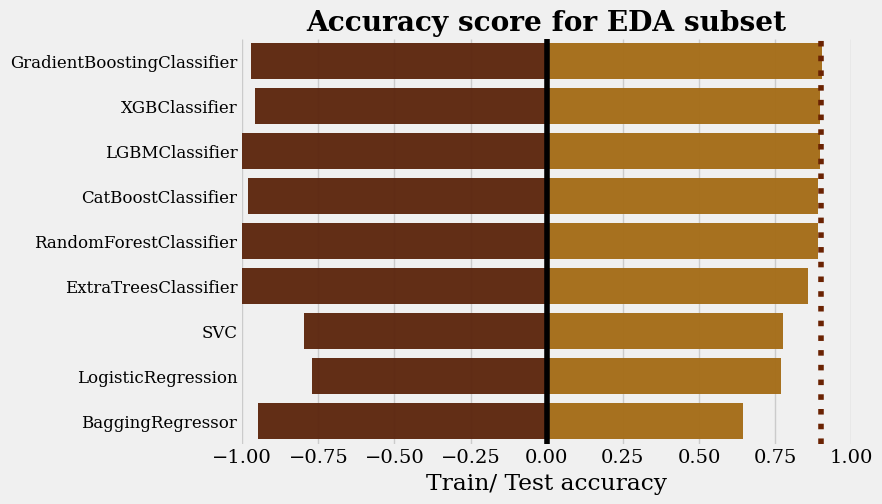

In [ ]:
plotscoring(scoreeda,'EDA subset',axvline=.9)

In [ ]:
tuningeda=[GradientBoostingClassifier(criterion='mse', learning_rate=0.05),
          CatBoostClassifier(leaf_estimation_method='Gradient',learning_rate=.1),
          AdaBoostClassifier(base_estimator=RandomForestClassifier(), learning_rate=0.5),
          LGBMClassifier(boosting_type='dart', subsample=0.8),
          XGBClassifier(booster='dart',max_depth=3,subsample=.8,n_estimators=277),
          RandomForestClassifier(min_samples_leaf=2, n_estimators=200)]

In [ ]:
score_tueda,_=selectmoran(tuningeda,X[eda_set])

Output streaming akan dipotong hingga 5000 baris terakhir.
0:	learn: 0.6117672	total: 3.62ms	remaining: 3.61s
1:	learn: 0.5413101	total: 9.14ms	remaining: 4.56s
2:	learn: 0.4801736	total: 13.2ms	remaining: 4.4s
3:	learn: 0.4320707	total: 22.6ms	remaining: 5.62s
4:	learn: 0.3996641	total: 37.4ms	remaining: 7.44s
5:	learn: 0.3765564	total: 43.7ms	remaining: 7.24s
6:	learn: 0.3440693	total: 51.1ms	remaining: 7.25s
7:	learn: 0.3219049	total: 54.7ms	remaining: 6.78s
8:	learn: 0.3076856	total: 57.1ms	remaining: 6.29s
9:	learn: 0.2953427	total: 59.7ms	remaining: 5.91s
10:	learn: 0.2834081	total: 62.4ms	remaining: 5.61s
11:	learn: 0.2756152	total: 65.7ms	remaining: 5.41s
12:	learn: 0.2619002	total: 69.5ms	remaining: 5.28s
13:	learn: 0.2557644	total: 73.2ms	remaining: 5.15s
14:	learn: 0.2494581	total: 76.7ms	remaining: 5.04s
15:	learn: 0.2414380	total: 80.3ms	remaining: 4.93s
16:	learn: 0.2363397	total: 83.2ms	remaining: 4.81s
17:	learn: 0.2294852	total: 86.3ms	remaining: 4.71s
18:	learn: 0.226

All features

Mean accuracy for all models: 0.8326325776317681

                        Model  Train_accuracy  Test_accuracy
5               XGBClassifier        0.968897       0.893250
6              LGBMClassifier        1.000000       0.891917
2      RandomForestClassifier        1.000000       0.890687
4  GradientBoostingClassifier        0.981481       0.890687
7          CatBoostClassifier        0.989149       0.889388
1        ExtraTreesClassifier        1.000000       0.852956
8                         SVC        0.791233       0.766986
0          LogisticRegression        0.771413       0.765636
3            BaggingRegressor        0.950187       0.652186


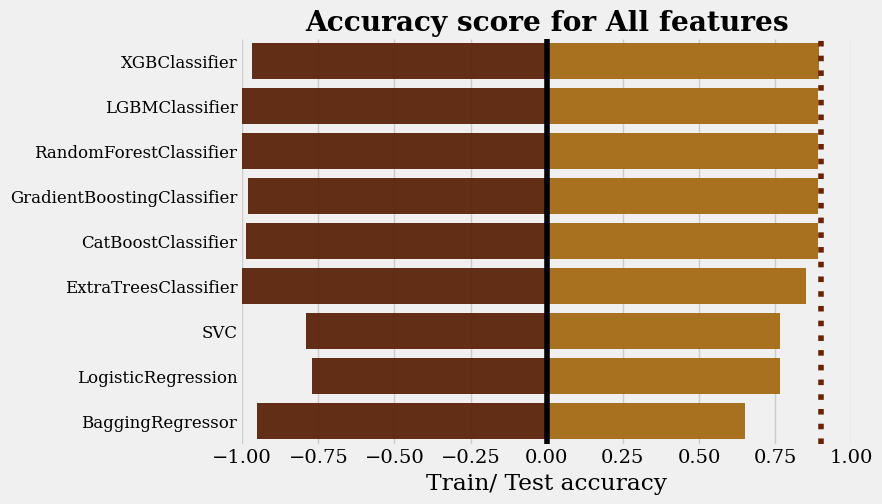

In [ ]:
plotscoring(scorefull,'All features',axvline=.9)

In [ ]:
tuningfull=[LGBMClassifier(boosting_type='dart', subsample=0.8, n_estimators=150, max_depth=3),
           CatBoostClassifier(leaf_estimation_method='Gradient',learning_rate=.3)]

In [ ]:
score_tuf,_=selectmoran(tuningfull,X)

Output streaming akan dipotong hingga 5000 baris terakhir.
0:	learn: 0.4876050	total: 3.49ms	remaining: 3.48s
1:	learn: 0.3532779	total: 6.81ms	remaining: 3.4s
2:	learn: 0.3021379	total: 11.1ms	remaining: 3.7s
3:	learn: 0.2633063	total: 16.1ms	remaining: 4.02s
4:	learn: 0.2445596	total: 19.8ms	remaining: 3.94s
5:	learn: 0.2293678	total: 22.9ms	remaining: 3.79s
6:	learn: 0.2146086	total: 26.5ms	remaining: 3.76s
7:	learn: 0.1998342	total: 30.6ms	remaining: 3.8s
8:	learn: 0.1912722	total: 34.9ms	remaining: 3.85s
9:	learn: 0.1828615	total: 38.8ms	remaining: 3.84s
10:	learn: 0.1790706	total: 42.2ms	remaining: 3.8s
11:	learn: 0.1756110	total: 45.8ms	remaining: 3.77s
12:	learn: 0.1668903	total: 49.4ms	remaining: 3.75s
13:	learn: 0.1606516	total: 53.5ms	remaining: 3.77s
14:	learn: 0.1549900	total: 57.5ms	remaining: 3.78s
15:	learn: 0.1482314	total: 61.3ms	remaining: 3.77s
16:	learn: 0.1439486	total: 64.6ms	remaining: 3.73s
17:	learn: 0.1339401	total: 67.6ms	remaining: 3.69s
18:	learn: 0.126247

Mean accuracy for all models: 0.8998120300751881

                Model  Train_accuracy  Test_accuracy
1  CatBoostClassifier         1.00000       0.902409
0      LGBMClassifier         0.94401       0.897215


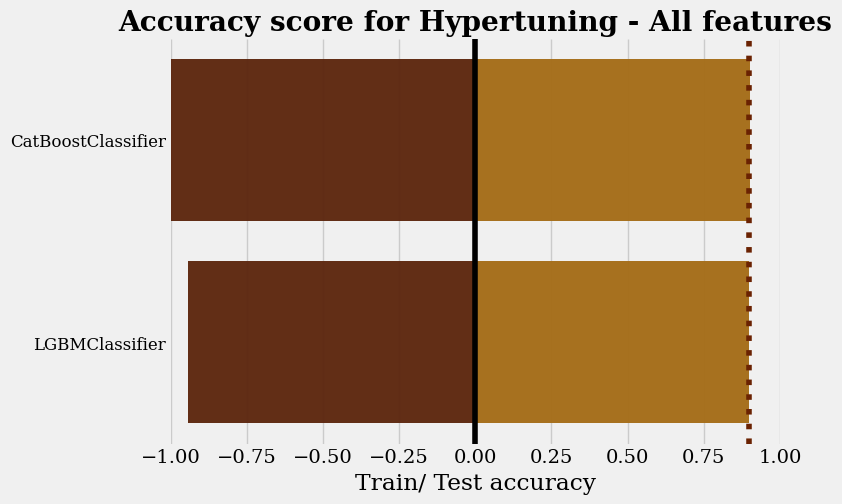

In [ ]:
plotscoring(score_tuf,'Hypertuning - All features',axvline=.9)